In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
# Import csv data
cwd = os.getcwd()
data = pd.read_csv(cwd+'/commodities_data.csv')
data['date'] = pd.to_datetime(data['date'])
data

/var/folders/cg/y1yc5_k11sj1gvc3tw7_nfc80000gn/T/ipykernel_47059/2323330813.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'])


,commodity,date,close
0,Gold,2000-08-30,273.899994
1,Gold,2000-08-31,278.299988
2,Gold,2000-09-01,277.000000
3,Gold,2000-09-05,275.799988
4,Gold,2000-09-06,274.200012
...,...,...,...
28309,Palladium,2023-11-13,978.400024
28310,Palladium,2023-11-14,1022.700012
28311,Palladium,2023-11-15,1036.400024
28312,Palladium,2023-11-16,1047.199951


In [4]:
# Calculates the daily percentage change of the closing price
data['pct_change_close'] = data.groupby('commodity')['close'].pct_change().fillna(0) * 100
data

,commodity,date,close,pct_change_close
0,Gold,2000-08-30,273.899994,0.000000
1,Gold,2000-08-31,278.299988,1.606424
2,Gold,2000-09-01,277.000000,-0.467117
3,Gold,2000-09-05,275.799988,-0.433217
4,Gold,2000-09-06,274.200012,-0.580122
...,...,...,...,...
28309,Palladium,2023-11-13,978.400024,0.359011
28310,Palladium,2023-11-14,1022.700012,4.527799
28311,Palladium,2023-11-15,1036.400024,1.339592
28312,Palladium,2023-11-16,1047.199951,1.042062


In [5]:
# Visualise closing prices of commodities
traces = []
metals = data['commodity'].unique()

for metal in metals:
    metal_data = data[data['commodity'] == metal]
    trace = go.Scatter(x = metal_data['date'],
                       y = metal_data['close'],
                       mode = 'lines',
                       name = metal)
    traces.append(trace)

fig = go.Figure(data=traces)
fig.show()

# Preprocessing

We preprocess the data so it is in a form suitable for machine learning algorithms to work. This can vary from cleaning (i.e. removing NaN values), transforming, encoding and scaling our data (normalising or standardising).

In [6]:
# Sort dataframe by percentage change of closing price based on commodity
data = data.pivot(index='date', columns='commodity', values='pct_change_close')
data = data.sort_values(by='date').dropna().reset_index().rename_axis(None, axis=1)
data

,date,Copper,Gold,Palladium,Platinum,Silver
0,2000-08-30,0.000000,0.000000,-2.059230,-0.420946,0.000000
1,2000-08-31,0.000000,1.606424,0.801633,-0.794726,1.480729
2,2000-09-01,0.451978,-0.467117,1.109175,1.465822,0.019996
3,2000-09-05,1.912263,-0.433217,-0.558850,1.007895,-0.119905
4,2000-09-06,-0.496692,-0.580122,2.407545,1.629800,-0.300127
...,...,...,...,...,...,...
4858,2023-11-13,2.204549,0.667496,0.359011,2.194136,0.378121
4859,2023-11-14,0.546075,0.837833,4.527799,3.407236,3.497918
4860,2023-11-15,0.950444,-0.086659,1.339592,1.026853,1.759176
4861,2023-11-16,-0.349698,1.214226,1.042062,0.201049,1.733019


In [7]:
# Filters data based on metals we want to use to predict gold price
input_col = ['Silver', 'Platinum', 'Copper', 'Palladium']
x = data[input_col]
x

,Silver,Platinum,Copper,Palladium
0,0.000000,-0.420946,0.000000,-2.059230
1,1.480729,-0.794726,0.000000,0.801633
2,0.019996,1.465822,0.451978,1.109175
3,-0.119905,1.007895,1.912263,-0.558850
4,-0.300127,1.629800,-0.496692,2.407545
...,...,...,...,...
4858,0.378121,2.194136,2.204549,0.359011
4859,3.497918,3.407236,0.546075,4.527799
4860,1.759176,1.026853,0.950444,1.339592
4861,1.733019,0.201049,-0.349698,1.042062


In [8]:
# Outputs to our model - Features we want to predict
output_col = ['Gold']
y = data[output_col]
y

,Gold
0,0.000000
1,1.606424
2,-0.467117
3,-0.433217
4,-0.580122
...,...
4858,0.667496
4859,0.837833
4860,-0.086659
4861,1.214226


When doing machine learning, we break up our dataset into additional sets to train and test our model, known as splitting the data into a **training set** and **testing set**. We use our training set to train the model, whereas the test set is unseen data used to evaluate the performance of the model, i.e. whether it is capable of accurately predicting future values.

In [9]:
# Splits data so 80% of data is used to train the model and 20% of the last data used to predict and test the accuracy of the model
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
training_fraction = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=training_fraction, shuffle=False)

# Classification

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
# Add 1 day lag to the closing prices
x_clf = x.copy()
x_clf = x_clf.shift(-1).dropna()
x_clf

,Silver,Platinum,Copper,Palladium
0,1.480729,-0.794726,0.000000,0.801633
1,0.019996,1.465822,0.451978,1.109175
2,-0.119905,1.007895,1.912263,-0.558850
3,-0.300127,1.629800,-0.496692,2.407545
4,-0.963272,-0.752737,0.499172,3.157180
...,...,...,...,...
4857,0.378121,2.194136,2.204549,0.359011
4858,3.497918,3.407236,0.546075,4.527799
4859,1.759176,1.026853,0.950444,1.339592
4860,1.733019,0.201049,-0.349698,1.042062


In [12]:
# Add 1 day lag to the closing prices
y_clf = y.copy()
y_clf = y_clf.shift(-1).dropna()

# Sets positive percentange change of closing prices for next day to be 1 and negative to be 0 for classification
y_clf['Gold'].values[y_clf['Gold'].values >= 0] = 1
y_clf['Gold'].values[y_clf['Gold'].values < 0] = 0
y_clf

,Gold
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
4857,1.0
4858,1.0
4859,0.0
4860,1.0


In [13]:
# Splits data so 80% of data is used to train the model and 20% of the remaining data used to predict and test the accuracy of the model
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
training_fraction = 0.2
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(x_clf, y_clf, test_size=training_fraction, shuffle=False)

In [14]:
# Create logistic regression object
model = LogisticRegression()

# Fit model with the data
model.fit(x_train_clf, y_train_clf.values.ravel())

# Generate predictions
log_pred = model.predict(x_test_clf)
# Store predictions in df
clf_df = pd.DataFrame(data['date'][len(x_train_clf):])
# clf_df['Actual'] = y_clf[len(x_train_clf):]
clf_df = clf_df.join(y_clf)
clf_df = clf_df.dropna()
clf_df['Logistic Regression'] = log_pred
clf_df

,date,Gold,Logistic Regression
3889,2019-12-23,1.0,1.0
3890,2019-12-24,1.0,1.0
3891,2019-12-26,1.0,0.0
3892,2019-12-27,1.0,1.0
3893,2019-12-30,1.0,0.0
...,...,...,...
4857,2023-11-10,1.0,1.0
4858,2023-11-13,1.0,1.0
4859,2023-11-14,0.0,1.0
4860,2023-11-15,1.0,1.0


In [15]:
# Accuracy of model predictions
log_acc = model.score(x_test_clf, y_test_clf)

Confusion matrix is used to measure the performance of a classifier by counting the times of correct predictions (similar to comparing actual vs predicted values).

|| Predicted `Negative` | Predicted `Positive` |
|--|--|--|
|<b>Real `Negative`</b>|True Negatives| False Positives|
|<b>Real `Positive`</b> | False Negatives|True Positives|

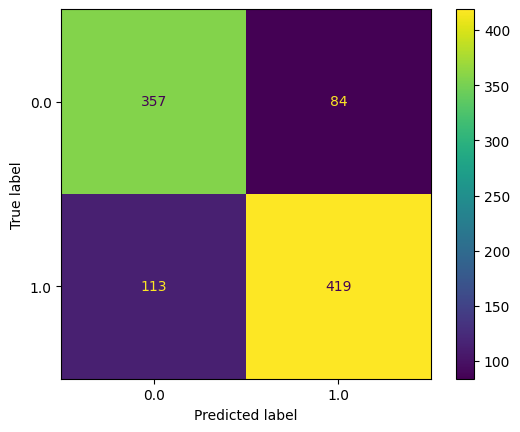

In [16]:
# Alternatives to visualise this is a ROC curve
# https://scikit-learn.org/1.0/auto_examples/model_selection/plot_roc.html
cm = confusion_matrix(y_test_clf, log_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [17]:
data['Gold'][len(x_train_clf):]

3889    0.528924
3890    1.119729
3891    0.680413
3892    0.298151
3893    0.046238
          ...   
4858    0.667496
4859    0.837833
4860   -0.086659
4861    1.214226
4862   -0.115936
Name: Gold, Length: 974, dtype: float64

In [18]:
# Calculate cumulative returns
clf_df['Cumulative Returns'] = (clf_df['Logistic Regression'] * data['Gold'][len(x_train_clf):]).cumsum()
clf_df

,date,Gold,Logistic Regression,Cumulative Returns
3889,2019-12-23,1.0,1.0,0.528924
3890,2019-12-24,1.0,1.0,1.648653
3891,2019-12-26,1.0,0.0,1.648653
3892,2019-12-27,1.0,1.0,1.946804
3893,2019-12-30,1.0,0.0,1.946804
...,...,...,...,...
4857,2023-11-10,1.0,1.0,6.016243
4858,2023-11-13,1.0,1.0,6.683739
4859,2023-11-14,0.0,1.0,7.521572
4860,2023-11-15,1.0,1.0,7.434913


In [19]:
# Backtesting with test data
fig = go.Figure()
fig.add_trace(go.Scatter(x=clf_df['date'], y=clf_df['Cumulative Returns'], mode='lines', name='Actual'))

fig.update_layout(xaxis_title='Date', yaxis_title='Cumulative Returns',
                  title=f'Gold Price - Logistic Regression Prediction Accuracy = {log_acc:.2f}')
fig.update_traces(line=dict(width=1))
fig.show()

# Regression

### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Create linear regression object
model = LinearRegression()

# Fit model with the data
model.fit(x_train, y_train)

# Generate predictions
lin_pred = model.predict(x_test)
# Store predictions in df
predict_df = pd.DataFrame(data['date'][len(x_train):])
predict_df['Actual'] = data['Gold'][len(x_train):]
predict_df['Linear Regression'] = lin_pred
predict_df

,date,Actual,Linear Regression
3890,2019-12-24,1.119729,0.857899
3891,2019-12-26,0.680413,0.432638
3892,2019-12-27,0.298151,-0.105256
3893,2019-12-30,0.046238,0.264181
3894,2019-12-31,0.330142,0.034077
...,...,...,...
4858,2023-11-13,0.667496,0.383574
4859,2023-11-14,0.837833,1.771697
4860,2023-11-15,-0.086659,0.802222
4861,2023-11-16,1.214226,0.721690


In [22]:
# Error metric - alternatives are MSE or RMSE
lin_mae = mean_absolute_error(y_test, lin_pred)
lin_mae

0.4967543221719977

In [23]:
# Backtesting with test data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['Gold'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=predict_df['date'], y=predict_df['Linear Regression'], mode='lines', name='Predicted'))

fig.update_layout(xaxis_title='Date', yaxis_title='Percentage Change',
                  title=f'Gold Price - Linear Regression MAE = {lin_mae:.2f}')
fig.update_traces(line=dict(width=1))
fig.show()

In [24]:
# Actual vs Predicted plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=predict_df['Actual'], y=predict_df['Linear Regression'], mode='markers', name='Model pre'))
# line of "perfect" fit to visualise error
fig.add_trace(go.Scatter(x=predict_df['Actual'], y=1*predict_df['Actual'], mode='lines'))

fig.update_layout(xaxis_title='Actual', yaxis_title='Predicted',
                  title=f'Gold Price - Linear Regression MAE = {lin_mae:.2f}',
                  xaxis_range=[-5,5], yaxis_range=[-5,5], showlegend=False)
fig.show()

### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
# Create decision tree object
model = DecisionTreeRegressor(random_state=42)

# Fit model with the data
model.fit(x_train, y_train)

# Generate predictions
dt_pred = model.predict(x_test)
predict_df['Decision Tree'] = dt_pred
predict_df

,date,Actual,Linear Regression,Decision Tree
3890,2019-12-24,1.119729,0.857899,1.236131
3891,2019-12-26,0.680413,0.432638,0.015789
3892,2019-12-27,0.298151,-0.105256,-0.692328
3893,2019-12-30,0.046238,0.264181,0.093053
3894,2019-12-31,0.330142,0.034077,0.206970
...,...,...,...,...
4858,2023-11-13,0.667496,0.383574,-2.019215
4859,2023-11-14,0.837833,1.771697,1.294039
4860,2023-11-15,-0.086659,0.802222,1.034087
4861,2023-11-16,1.214226,0.721690,0.287093


In [27]:
# Error metric - alternatives are MSE or RMSE
dt_mae = mean_absolute_error(y_test, dt_pred)
dt_mae

0.7403608813441875

In [28]:
# Backtesting with test data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['Gold'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=predict_df['date'], y=predict_df['Decision Tree'], mode='lines', name='Predicted'))

fig.update_layout(xaxis_title='Date', yaxis_title='Percentage Change',
                  title=f'Gold Price - Decision Tree MAE = {dt_mae:.2f}')
fig.update_traces(line=dict(width=1))
fig.show()

In [29]:
# Actual vs Predicted plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=predict_df['Actual'], y=predict_df['Decision Tree'], mode='markers', name='Model pre'))
# line of "perfect" fit to visualise error
fig.add_trace(go.Scatter(x=predict_df['Actual'], y=1*predict_df['Actual'], mode='lines'))

fig.update_layout(xaxis_title='Actual', yaxis_title='Predicted',
                  title=f'Gold Price - Decision Tree MAE = {lin_mae:.2f}',
                  xaxis_range=[-5,5], yaxis_range=[-5,5], showlegend=False)
fig.show()

# Hyperparameter Tuning

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [31]:
# Create random forest object
model = RandomForestRegressor(random_state=42)

# Create the random grid for parameters to optimise model
# Refer to documentation for what these parameters mean and what you can optimise
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
model_params = {'n_estimators': np.arange(20,120,20),
               'max_depth': np.linspace(10,100,10).astype(int),
               'min_samples_split': np.linspace(0,10,6).astype(int),
               'min_samples_leaf': np.linspace(0,10,6).astype(int)}

# Trains 10 models over 5 folds of cross validation based on given parameters to quickly search optimal
model = RandomizedSearchCV(model, model_params, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)

# Fit model with the data
model.fit(x_train, y_train.values.ravel())

# Print best set of hyperparameters for this model
model.best_estimator_.get_params()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 60,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [32]:
# Generate predictions
rf_pred = model.predict(x_test)
predict_df['Random Forest'] = rf_pred
predict_df

,date,Actual,Linear Regression,Decision Tree,Random Forest
3890,2019-12-24,1.119729,0.857899,1.236131,0.793444
3891,2019-12-26,0.680413,0.432638,0.015789,0.528733
3892,2019-12-27,0.298151,-0.105256,-0.692328,-0.142927
3893,2019-12-30,0.046238,0.264181,0.093053,0.311835
3894,2019-12-31,0.330142,0.034077,0.206970,0.038594
...,...,...,...,...,...
4858,2023-11-13,0.667496,0.383574,-2.019215,0.396671
4859,2023-11-14,0.837833,1.771697,1.294039,1.976086
4860,2023-11-15,-0.086659,0.802222,1.034087,1.251667
4861,2023-11-16,1.214226,0.721690,0.287093,0.710550


In [33]:
# Error metric - alternatives are MSE or RMSE
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mae

0.5201844853478966

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['Gold'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=predict_df['date'], y=predict_df['Random Forest'], mode='lines', name='Predicted'))

fig.update_layout(xaxis_title='Date', yaxis_title='Percentage Change',
                  title=f'Gold Price - Random Forest MAE = {rf_mae:.2f}')
fig.update_traces(line=dict(width=1))
fig.show()

In [35]:
# Actual vs Predicted plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=predict_df['Actual'], y=predict_df['Random Forest'], mode='markers', name='Model pre'))
# line of "perfect" fit to visualise error
fig.add_trace(go.Scatter(x=predict_df['Actual'], y=1*predict_df['Actual'], mode='lines'))

fig.update_layout(xaxis_title='Actual', yaxis_title='Predicted',
                  title=f'Gold Price - Random Forest MAE = {lin_mae:.2f}',
                  xaxis_range=[-5,5], yaxis_range=[-5,5], showlegend=False)
fig.show()